# TD4: Résaux de neurones : modèles de taux de décharge

Dans ce TD, nous allons étudier la dynamique de réseaux de neurones où différentes *populations de neurones* sont représentés par leur taux de décharge moyen. Ces populations peuvent être couplées par des connexions synaptiques, ce qui rend la dynamique de ces modèles potentiellement très riche.

Par ailleurs, ces modèles sont aussi très étudiés comme une approximation de réseaux récurrents de neurones, où le couplage entre toutes les unités, avec certaines contraintes, peut produire n'importe quel dynamique souhaité suite à un apprentissage des poids des connexions.

Ici, nous allons d'abord étudier des réseaux à basse dimension, c'est-à-dire avec une ou deux populations de neurones, pour développer une compréhension des modèles à taux de décharge. Si le temps le permet, nous pourrons implémenter une version du "bump attractor model" que nous avons rapidement vu dans le cours.

## 1| Une seule population avec connexions récurrentes

Pour une seule population de neurones, la dynamique du taux de décharge $r(t)$ est donné par l'équation différentielle

$$\frac{dr}{dt} = \frac{\Phi(I_{ext}+wr(t)) - r(t)}{\tau},$$ 

où $\Phi(I)$ est la *fonction de transfert*, ou courbe $f-I$, qui donne le taux de décharge stationnaire du réseau pour un courant constant $I$. Dans le modèle, le courant synaptique que la population reçoit est donné par la somme d'une courant provénant d'autres régions du cervau ou d'autres populations de neurones, $I_{ext}$, et le courant synaptique lié aux connexions récurrentes, proportionnel au taux de décharge de la population même, $I_{rec}=w r(t)$, avec un poids de connexion effective $w$. Pour des neurones excitateurs, $w>0$, pour des neurones inhibiteurs, $w<0$. Enfin, $\tau$ est le temps caractéristique de la relaxation du taux de décharge vers la valeur stationnaire. 



### La fonction de transfert

On peut choisir différentes fonctions pour $\Phi(I)$, seulement il faut que la fonction soit toujours positive, $\Phi(I)\ge 0$, et monotone, $\Phi(I_1)\ge \Phi(I_2)$ si $I_1>I_2$.

Ici, on va utiliser une sigmoïde, 
$$\Phi(I) = r_{max} \frac{\tanh[\kappa(I-I_{half})] + 1}{2},$$
avec les paramètres suivants : $r_{max}$ - le taux de décharge maximale, $\kappa$ - la 'raideur' de la courbe $f-I$, et $I_{half}$ - le courant pour lequel le taux de décharge sera $r_{max}/2$.

Ce choix est assez "générique" dans le sens où la fonction ressemble à des courbes $f-I$ observées, tout en étant très aisément parametrisable, et implémenter numériquement. L'inverse et la dérivé sont également connues, ce qui s'averera utile pour des calculs. 

**Remarque :** Une fois implémenté, nous n'avons plus à nous soucier de la fonction de transfert dans nos simulations ou calculs, qu'elle soit compliquée ou non !


In [1]:
# import necessary modules for numerics and plotting
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Definition of the f-I curve 

# set standard parameters 
# --> these will be used as default parameters
# in the function definitions
rmax = 500.0     # (could be Hz)
Ihalf = 10.0   # (could be pA)
kappa = 0.2  # (1/unit of current)

# f-I curve
def fI(I):
    """fI(I, kwargs**) returns the population firing rate (in Hz) 
    for a given input current I (in mV)."""
    return rmax*0.5*(1.0+np.tanh((I-Ihalf)*kappa))

# we need the inverse function as well:
def fI_inv(r):
    y = 2.0*r/rmax - 1.0
    return np.arctanh(y)/kappa + Ihalf

# and also its derivative with respect to current
def fI_deriv(I):
    y = (I-Ihalf)*kappa
    return rmax*0.5*(1.0-np.tanh(y)**2)*kappa

Text(0, 0.5, 'r (Hz)')

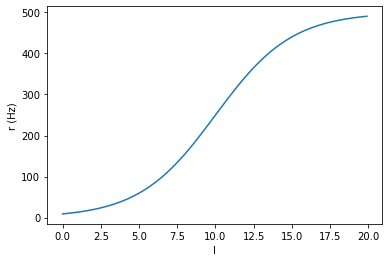

In [3]:
# Plotez la courbe f-I, c.à.d., le taux de décharge
# vs. le courant entrant total
# (Vous pouvez jouer avec les paramètres pour voir 
# comment la courbe se modifie.)

I = np.arange(0,20,0.1)

fig, ax = plt.subplots()
ax.plot(I, fI(I))
ax.set_xlabel('I')
ax.set_ylabel('r (Hz)')


/Users/jranft/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: divide by zero encountered in arctanh


Text(0, 0.5, 'I')

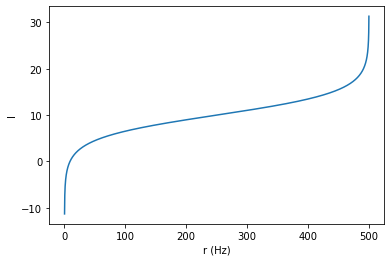

In [4]:
# Plottez l'inverse de la courbe f-I
# --> est-ce qu'elle est définie pour 
# toutes les valeurs de r ?

rs = np.arange(0,rmax,0.1)

fig, ax = plt.subplots()
ax.plot(rs, fI_inv(rs))
ax.set_xlabel('r (Hz)')
ax.set_ylabel('I')

Text(0, 0.5, "$\\Phi'(I)$ (Hz/[I])")

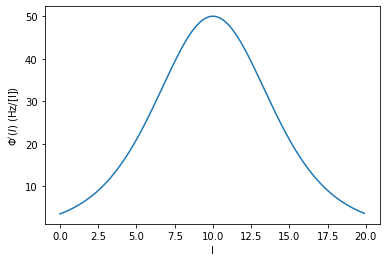

In [5]:
# Plottez la dérivée de la courve f-I

fig, ax = plt.subplots()
ax.plot(I, fI_deriv(I))
ax.set_xlabel('I')
ax.set_ylabel(r"$\Phi'(I)$ (Hz/[I])")

### Dynamique avec courant externe constant

Pour un courant externe constant, on peut se demander si le réseau va atteindre un état stationnaire et si cet état sera stable. 

La première possibilité d'y répondre, c'est de resoudre numériquement l'équation différentielle et de déterminer ainsi la solution pour $r(t)$. 

#### Inhibitory network

Plottez $r(t)$ pour différentes valeurs de $I_{ext}$ et de $w<0$, chaque fois pour des valeurs initiales $r(t=0)=0$ et $r(t=0)= r_{max}$. Qu'est-ce que vous observez ?   

In [63]:
tau = 10. # ms


# définissez la dérivée dr/dt(r,t) (la fonction 'f'
# des TD précédents) 
def drdt(r, t, Iext, w):
    Itotal = Iext + w*r
    return (fI(Itotal) - r)/tau

# Intégration numérique
# --> odeint ou la méthode d'Euler

from scipy.integrate import odeint

t = np.arange(0,100,1)
nt = len(t)

r0s = [0, 10, 20, rmax]

Iext = 20.
w = -2

rts = []
#for i, r0 in enumerate(r0s):
#--> for i in range(len(r0s)):
#        r0 = r0s[i]
#        ...   
for r0 in r0s: 
    # pas de 'i' disponible ici (mais pas besoin)
    r_of_t = odeint(drdt, r0, t, args=(Iext,w))
    rts.append(r_of_t)


(0, 20)

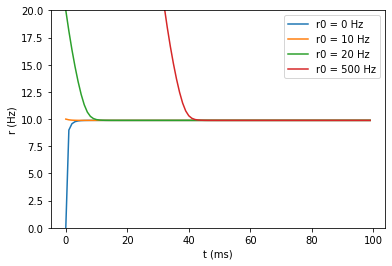

In [64]:
fig, ax = plt.subplots()
for i, r0 in enumerate(r0s):
    ax.plot(t, rts[i], label='r0 = %g Hz'%r0)
ax.set_xlabel('t (ms)')
ax.set_ylabel('r (Hz)')
ax.legend()
ax.set_ylim(0,20)

Est-ce qu'il y a la possibilité de déterminer l'état stationnaire ($r(t)=r^*=const.$) en partant de l'équation ? Plottez $dr/dt$ en fonction de $r$ pour les valeurs de $I_{ext}$ et $w$ choisies. Qu'est-ce que vous observez ?

Text(0, 0.5, 'dr/dt (Hz/ms)')

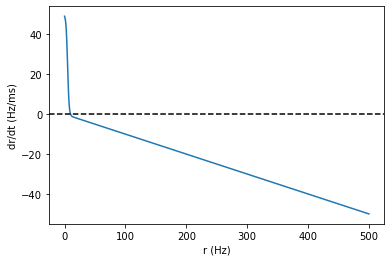

In [65]:
fig, ax = plt.subplots()
ax.plot(rs, drdt(rs, None, Iext, w))
ax.set_xlabel('r (Hz)')
ax.axhline(0, ls='--', c='k')
ax.set_ylabel('dr/dt (Hz/ms)')
#ax.set_xlim(0,20)

**Remarque :** L'état stationnaire $r^*$ satisfait la condition suivante : 
$$\Phi(I_{ext}+wr^*) - r^* = 0.$$
Pour des fonctions de transfert $\Phi$ plus compliquées (dans notre cas, la sigmoïde est une fonction *transcendante*), cette équation n'a pas de solution analytique. Pour l'instant, contentons-nous d'inspecter le(s) zéro(s) de $dr/dt$ graphiquement.

#### Excitatory network

Plottez $r(t)$ pour différentes valeurs de $I_{ext}$, maintenant avec une valeur $w>0$, chaque fois pour des valeurs initiales $r(t=0)=0$ et $r(t=0)= r_{max}$. Qu'est-ce que vous observez ?

In [70]:
Iext = -10
w = 0.1

rts = []

for r0 in r0s: 
    # pas de 'i' disponible ici (mais pas besoin)
    r_of_t = odeint(drdt, r0, t, args=(Iext,w))
    rts.append(r_of_t)


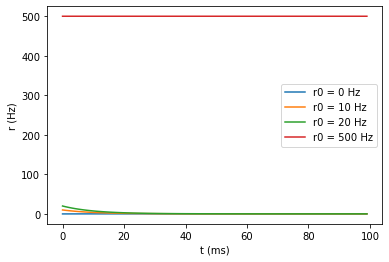

In [71]:
fig, ax = plt.subplots()
for i, r0 in enumerate(r0s):
    ax.plot(t, rts[i], label='r0 = %g Hz'%r0)
ax.set_xlabel('t (ms)')
ax.set_ylabel('r (Hz)')
ax.legend()
#ax.set_ylim(0,20)

Si vous plottez maintenant $dr/dt$ en fonction de $r$, qu'est-ce que vous observez ? A combien d'états stationnaires vous attendez-vous ?

Text(0, 0.5, 'dr/dt (Hz/ms)')

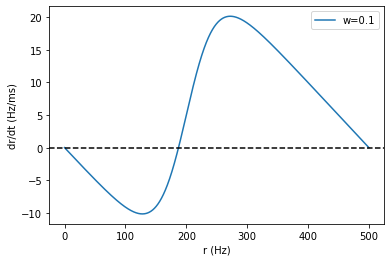

In [72]:
fig, ax = plt.subplots()
ax.plot(rs, drdt(rs,None,Iext,w), label='w=%g'%w)
ax.axhline(0, ls='--', c='k')
ax.legend()
ax.set_xlabel('r (Hz)')
ax.set_ylabel('dr/dt (Hz/ms)')
#ax.set_ylim(-1,1)

Maintenant pour une valeur de $I_{ext}$ choisie, plottez $dr/dt$ et variez le poids de la connexion récurrente $w$. Est-ce que vous pouvez observez un changement *qualitatif* ?

Text(0, 0.5, 'dr/dt (Hz/ms)')

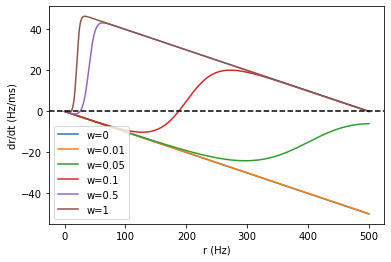

In [76]:
# vérifiez des poids très petits à très grands
ws = np.array([0., 0.01, 0.05, 0.1,0.5, 1 ])

fig, ax = plt.subplots()
for w in ws:
    ax.plot(rs, drdt(rs,None,Iext,w), label='w=%g'%w)
ax.axhline(0, ls='--', c='k')
ax.legend()
ax.set_xlabel('r (Hz)')
ax.set_ylabel('dr/dt (Hz/ms)')
#ax.set_ylim(-1,1)

On constate l'apparition de deux états stationnaires ($dr/dt=0$) supplémentaires pour $w$ suffisamment grand !

Nous pouvons également regarder la variation avec $I_{ext}$ :

Text(0, 0.5, 'dr/dt (Hz/ms)')

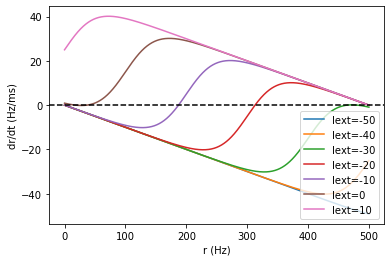

In [85]:
w = 0.1
Iexts = np.arange(-50,11,10)

fig, ax = plt.subplots()
for Iext in Iexts:
    ax.plot(rs, drdt(rs,None,Iext,w), label='Iext=%g'%Iext)
ax.axhline(0, ls='--', c='k')
ax.legend()
ax.set_xlabel('r (Hz)')
ax.set_ylabel('dr/dt (Hz/ms)')


La présence ou absence de plusieurs points fixes dépend également de $I_{ext}$. Vous pouvez vérifiez que plus $I_{ext}$ est faible, plus le $w$ à partir lequel les deux points fixes supplémentaires apparaissent est grand. Pour $I_{ext}$ suffisamment grand, les deux points fixes à faible taux de décharge disparaissent complètement, et il ne reste que le point fixe à très forte décharge.

Lorsque vous observez plusieurs points fixes $r^*$ pour lesquels $dr/dt=0$ (pour des paramètres $I_{ext}$ et $w$ fixes choisis), pouvez-vous estimer si ces points fixes sont stables ou pas ? Vérifiez avec une intégration numérique de la dynamique, en partant de près de chaque point fixe ($r(t=0) = 1.01 r^*_1$ pour le premier, ($r(t=0) = 1.01 r^*_2$ pour le deuxième etc.).

(10, 50)

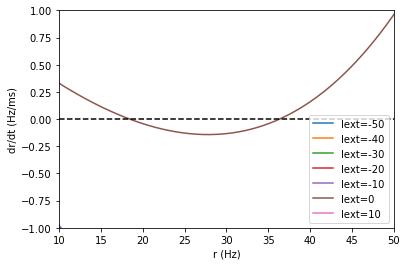

In [86]:
# zoom sur les deux premières 
# points fixes pour Iext = 0 :
fig, ax = plt.subplots()
for Iext in Iexts:
    ax.plot(rs, drdt(rs,None,Iext,w), label='Iext=%g'%Iext)
ax.axhline(0, ls='--', c='k')
ax.legend()
ax.set_xlabel('r (Hz)')
ax.set_ylabel('dr/dt (Hz/ms)')
ax.set_ylim(-1,1)
ax.set_xlim(10,50)

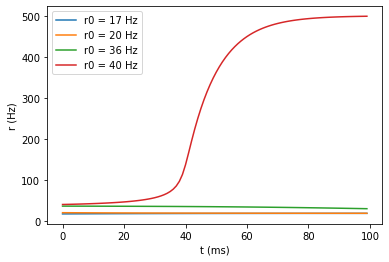

In [87]:
r0s_fp = [17, 20, 36, 40]

Iext = 0
w = 0.1

rts = []

for r0 in r0s_fp: 
    # pas de 'i' disponible ici (mais pas besoin)
    r_of_t = odeint(drdt, r0, t, args=(Iext,w))
    rts.append(r_of_t)

fig, ax = plt.subplots()
for i, r0 in enumerate(r0s_fp):
    ax.plot(t, rts[i], label='r0 = %g Hz'%r0)
ax.set_xlabel('t (ms)')
ax.set_ylabel('r (Hz)')
ax.legend()

Est-ce que la stabilité peut être prédite par l'équation ? Considerez la dynamique d'une petite variation $\delta r$ autour du point fixe $r^*$, de sorte que $r(t) = r^* + \delta r(t)$. 

**Astuce :** Nous pouvons approximer une fonction $h(x)$ autour d'un point $x_0$ par sa dérivée selon de développement (jusqu'au premier ordre) :
$$h(x)\approx h(x_0) + h'(x_0)(x-x_0).$$ 

In [88]:
# calcul sur papier, puis évaluation numérique...

$
\begin{aligned}
\tau \frac{d\delta r}{dt} &= \Phi(I_{ext} + w(r^* + \delta r)) - r^* - \delta r \\
&= \Phi(I_{ext}+w r^*) - r^* + \Phi'(I_{ext}+w r^*) w \delta r - \delta r \\
&= (\Phi'(I_{ext}+w r^*) w -1 ) \delta r 
\end{aligned}$

On constate qu'une petite perturbation va croitre/diminuer comme $\delta r(t) = \delta r(0) e^{\lambda t}$, avec le taux caractéristique $\lambda = \frac{\Phi'(I_{ext}+w r^*) w -1 }{\tau}$. Si $\lambda>0$, le point fixe $r^*$ est instable car chaque petite perturbation va croitre (le taux de décharge dévier d'avantage du point fixe) ; si $\lambda<0$, le point fixe est stable et $r(t)\to r^*$ avec $\delta r(t)\to 0$ pour une perturbation initiale $\delta r(0)$ suffisamment petite.

### Extra : détermination numérique d'un point fixe

Il n'est pas possible de calculer analytiquement le(s) point(s) fixe(s) $r^*$ pour qui $\frac{dr}{dt}=0$, ou

$$0 = \Phi(I_{ext}+wr^*) - r^*.$$

Par contre, nous pouvons trouver cette solution *numériquement*, par ex. en utilisant la fonction `brentq` du module `scipy.optimize`. Elle permet de déterminer le zéro d'une fonction $f$ si le zéro est situé entre deux valeurs $a,b$ pour lesquelles $f(a)\cdot f(b) <0 $ (c'est-à-dire pour l'une des valeurs la fonction est négative et pour l'autre positive). 

Une fois le point fixe trouvé, nous pouvons utiliser l'analyse ci-dessus pour vérifier sa stabilité !

In [89]:
from scipy.optimize import brentq
brentq?

In [90]:
# Restons sur le dernier exemple étudié :
# --> nous connaissons approximativement 
# la position de deux points fixes 
Iext = 0
w = 0.1

# point fixe stable :
rstar1 = brentq(drdt, 15, 30, args=(None,Iext,w))
print('Numerically determined fixed point:', rstar1, 'Hz')

# vérification de stabilité :
lam1 = (w*fI_deriv(Iext+w*rstar1)-1)/tau
print('Characteristic rate:', lam1, '1/ms')
if lam1<0:
    print('--> this fixed point is stable!')
else:
    print('--> this fixed point is unstable!')
print()

# point fixe instable :
rstar2 = brentq(drdt, 30, 50, args=(None,Iext,w))
print('Numerically determined fixed point:', rstar2, 'Hz')

# vérification de stabilité :
lam2 = (w*fI_deriv(Iext+w*rstar2)-1)/tau
print('Characteristic rate:', lam2, '1/ms')
if lam2<0:
    print('--> this fixed point is stable!')
else:
    print('--> this fixed point is unstable!')
print()

Numerically determined fixed point: 18.446664889217132 Hz
Characteristic rate: -0.028935576007411833 1/ms
--> this fixed point is stable!

Numerically determined fixed point: 36.35621628968949 Hz
Characteristic rate: 0.03485066945553659 1/ms
--> this fixed point is unstable!



## 2| Deux populations couplées : le réseau Excitateur-Inhibiteur


Pour deux populations de neurones excitateurs et inhibiteurs, un modèle de taux de décharge peut prendre la forme suivante :

$$\tau \frac{d r_E(t)}{dt} =  \Phi(I_{ext,E} + w_{EE}r_E(t) + w_{EI}  r_I(t) )  -  r_E(t) $$
$$\tau \frac{d r_I(t)}{dt} =  \Phi(I_{ext,I} + w_{IE}r_E(t) + w_{II}  r_I(t) )  -  r_I(t) $$

Ici, il y a désormais quatre poids effectifs de connexions synaptiques, des excitateurs vers excitateurs et inhibiteurs, $w_{EE}, w_{IE} >0$, et des inhibiteurs vers excitateurs et inhibiteurs, $w_{EI}, w_{II} < 0$. Pour réduire la compléxité, nous considérons $w_{II}=0$ par la suite.

Pouvez-vous intégrer numériquement les équations dynamiques couplées pour $r_E(t), r_I(t)$ ? 

**Astuce :** Nous pouvons écrire la dynamique (comme pour le modèle FitzHugh-Nagumo) pour un système "vectoriel" à deux dimensions, $\vec{r}(t) = (r_E(t), r_I(t))$.

**Remarque :** Au lieu de chercher le ou les point(s) fixe(s) pour des paramètres donnés, il est beaucoup plus simple d'imposer un point fixe $\vec{r}^* = (r_E^*, r_I^*)$ et de déterminer le courant externe nécessaire qu'il faut pour obtenir ce point fixe, quand la matrice des connexions est donnée :

$$
\begin{aligned}
\Phi(\vec{I}_{ext}+W\vec{r}^*) - \vec{r}^* &= 0 \\
\Leftrightarrow \quad \Phi(\vec{I}_{ext}+W\vec{r}^*) &= \vec{r}^* \\
\Leftrightarrow\quad  \vec{I}_{ext} + W\vec{r}^* &= \Phi^{-1}(\vec{r})^* \\
\Leftrightarrow \quad \vec{I}_{ext} &= \Phi^{-1}(\vec{r})^* - W\vec{r}^*,
\end{aligned}
$$

où $\Phi^{-1}(r)$ est la fonction inverse de $\Phi(I)$. 
*Attention* : Si on a ainsi fait en sorte de connaître très précisement le point fixe, il faut surtout éviter de choisir le point fixe comme valeur(s) intiale(s) pour la dynamique, car au point fixe rien ne se passe par définition - il faut choisir un point de départ légèrement décalé. (C'était cela que j'avais oublié lorsque j'ai essayé de montrer l'activité du réseau à deux populations en *live*.)

In [91]:
# définir la dynamique pour le vecteur
# r = (r_E, r_I)

def drdt_explicit(r, t, Iext, W):
    rE, rI = r
    wEE, WEI, wIE, wII = W.flatten()
    IEtotal = Iext[0] + wEE*rE + wEI*rI
    IItotal = Iext[1] + wIE*rE + wII*rI
    drEdt = (fI(IEtotal) - rE)/tau
    drIdt = (fI(IItotal) - rI)/tau
    return np.array([drEdt, drIdt])

# --> beaucoup plus élégant : la
# fonctionnalité du calcul vectoriel 
# avec les arrays de numpy

def drdt_matrix(r, t, Iext, W):
    Itotal = Iext + W.dot(r)
    return (fI(Itotal) - r)/tau

# la matrice des poids de connexions
# récurrentes et entre populations

W = np.array([[1.1, -1 ],
              [1, 0.]])

# au lieu

rstar = np.array([5., 10.])
Iext = fI_inv(rstar) - W.dot(rstar)

r0 = 1.1 * rstar

t = np.arange(0,1000,1)

rt = odeint(drdt_matrix, r0, t, args=(Iext, W))

Text(0, 0.5, 'r (Hz)')

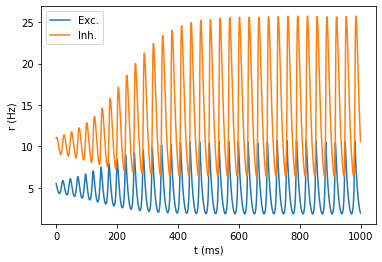

In [92]:
fig, ax = plt.subplots()
ax.plot(t, rt)
ax.legend(labels=['Exc.', 'Inh.'])
ax.set_xlabel('t (ms)')
ax.set_ylabel('r (Hz)')

On voit bien l'émergence d'une oscillation d'activité des deux populations ! Cela s'appele un *cycle limite*, qui apparaît très clairement si on plotte $r_I$ vs. $r_I$ (dans un tel plot, on perd la notion temporelle par contre) :


Text(0, 0.5, '$r_I$ (Hz)')

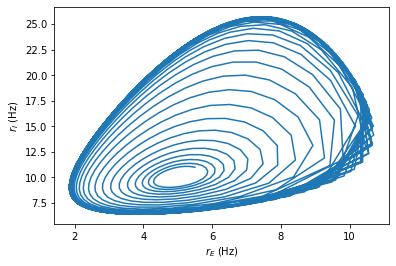

In [94]:
fig, ax = plt.subplots()
ax.plot(rt[:,0], rt[:,1])
ax.set_xlabel('$r_E$ (Hz)')
ax.set_ylabel('$r_I$ (Hz)')